# Smoke Alarm install model
### this notebook represents the current smoke alarm install model

In [1]:
import pandas as pd
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 


In [2]:
# import stored methods 
path = Path.cwd().parent.parent
LoadAndCleanACS = path /'src' /'data'/ 'LoadAndCleanACS.py'
LoadAndCleanARCP = path /'src' /'data'/ 'LoadAndCleanARCP.py'



In [3]:
# Run methods to obtain clean datasets 
%run $LoadAndCleanACS
%run $LoadAndCleanARCP


In [4]:
# to allow for all variables to be displayed in jupyter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
def StandardizeColumnNames(df):
    """
    Standardizes column names
    """
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace(', ', '_')
    df.columns = df.columns.str.replace('-', '_')
    df.columns = df.columns.str.replace('/', '_')
    df.columns = df.columns.str.replace('(', '_')
    df.columns = df.columns.str.replace(')', '_')
    df.columns = df.columns.str.replace(' ', '_')
    #print(df.columns)
    return df

### Data

In [6]:
input_loc =  path /'Data'/ 'Master Project Data'
output_loc = path /'Data'/ 'processed'

In [7]:
arc_path = input_loc / 'ARC Preparedness Data.csv'
arc = pd.read_csv(arc_path, 
                  dtype = {'GEOID': str, 'Zip': str})
arc = StandardizeColumnNames(arc)
arc.dropna(inplace = True)
# trim geoid leading saftey marks 
arc['geoid'] = arc['geoid'].str[2:]
arc.head()

,geoid,census_block_group_y,census_block_group_x,city,state,zip,county,in_home_visit_date,smoke_alarms_installed__9_volt_10_year_dhh_,10_year_and_9_volt_alarms_installed,dhh_alarms_installed,pre_existing_alarms,pre_existing_alarms_tested_and_working,batteries_replaced,fire_escape_plans_made,fire_safety_checklists_completed,additional_hazard_education_conducted,additional_hazard_type,people_served,youth_served,seniors_served,veterans_military_members_and_military_family_members_served,individuals_with_disabilities_access_or_functional_needs_served
12,010010205002,32.470418,-86.424166,PRATTVILLE,AL,36066,Autauga,9/9/2016,1,1,0,0.0,0.0,0,1,1,0,None,2,0,0,0,0
18,010010208012,32.455173,-86.534591,PRATTVILLE,AL,36067,Autauga,9/30/2019,2,2,0,0.0,0.0,0,1,1,1,Tornadoes,5,0,0,1,0
23,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,5/4/2019,3,2,1,0.0,0.0,0,1,1,1,Other,1,0,0,0,0
24,010010208021,32.524822,-86.573009,PRATTVILLE,AL,36067,Autauga,9/27/2019,1,1,0,0.0,0.0,0,1,1,1,Tornadoes,1,0,0,0,0
27,010010208023,32.543983,-86.492100,PRATTVILLE,AL,36067,Autauga,12/2/2017,3,3,0,0.0,0.0,0,1,1,0,None,1,0,0,0,0


## EDA  

- remove all houses that don't have a previous smoke detector record 
- Determine the median number of house visist
- Visualize visit distribution 
- use ACS data to determine % of blocks visited 
- determine % blocks visited with >15 visits 

In [8]:
#block level
counts = arc['geoid'].value_counts()
counts_median = counts.median()
counts.describe()


count    87725.000000
mean         6.132619
std         15.250533
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1863.000000
Name: geoid, dtype: float64

## EDA- Geograpic Level
 repeat block Level analysis at various levels

In [9]:
# county
county_counts =  arc['geoid'].str[:7].value_counts()
print('County Level')
print(county_counts.describe())
# state 
state_counts =  arc['geoid'].str[:2].value_counts()
print('\n State Level')
print(state_counts.describe())

County Level
count    3605.000000
mean      149.232732
std       331.121218
min         1.000000
25%        10.000000
50%        47.000000
75%       148.000000
max      6579.000000
Name: geoid, dtype: float64

 State Level
count       52.000000
mean     10345.846154
std      12099.256714
min          3.000000
25%       2130.500000
50%       7135.500000
75%      12123.000000
max      51826.000000
Name: geoid, dtype: float64


In [10]:
print(arc['pre_existing_alarms'].describe())
print(arc['pre_existing_alarms_tested_and_working'].describe())

count    537984.000000
mean          1.507301
std           1.552540
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: pre_existing_alarms, dtype: float64
count    537984.000000
mean          0.829638
std           1.336587
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           9.000000
Name: pre_existing_alarms_tested_and_working, dtype: float64


## Confidence Interval Motivation 

A commonly used formula for a binomial confidence interval relies on approximating the distribution of error about a binomially-distributed observation, ${\displaystyle {\hat {p}}}$, with a normal distribution. This approximation is based on the central limit theorem and is unreliable when the sample size is small or the success probability is close to 0 or 1.

Using the normal approximation, the success probability p is estimated as

${\displaystyle {\hat {p}}\pm z{\sqrt {\frac {{\hat {p}}\left(1-{\hat {p}}\right)}{n}}},}$

Source https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

In [11]:
def CreateConfidenceIntervals(num_surveys,percentage):
# this function takes the cleaned data and adds a confidence interval 

    z =	1.960 # corresponds to 95% confidence interval
    
    CI =  z * np.sqrt(
                     (percentage * (100 - percentage) ) / 
                      num_surveys  )

    return CI


### Feature Engineering
 Create Binary variables out of the smoke_alarms_present and smoke_alarms_tested_and_working variables 
 
 We'll then create a new dataset with the aggregated number and percantage of working smoke detectors in each census geography

In [12]:
def CreateSingleLevelSmokeAlarmModel(df,geo_level):
# This function takes the arc data  into a dataset containing the percentage 
# and number of smoke detectors by census geography
#
# Inputs 
# arc-  the arc dataset
#
# geo_level- String var indcating what census geography to aggregate on. current levels are:
# State,County,Block,State
#
# The resultant dataset will have the following values:
#
#   num_surveys - total number of surveys conducted
#
#   detectors_found -   houses with at least one smoke detector in the home
#
#   detectors_workding - houses with at least one tested and working smoke detector in the home
#
#   Note: for variables the suffixes 
#       _total- indicates raw counts 
#        _prc  - indicates percentage: (_total / num_surveys * 100)
#
   
    # dict with relevant length of GEOID for tract geography
    geo_level_dict = {'State':2,'County':5,'Tract':11,'Block':12}
    
    df['geoid'] = df['geoid'].str[: geo_level_dict[geo_level]]
    
    ## binarize pre_existing_alarms and _tested_and_working
    #  values will now be: 0 if no detectors present and 1 if any number were present
    df['pre_existing_alarms'].where(df['pre_existing_alarms'] < 1, other = 1, inplace = True) 
    df['pre_existing_alarms_tested_and_working'].where(
                                                        df['pre_existing_alarms_tested_and_working'] < 1,
                                                            other = 1, 
                                                            inplace = True)

    ## create detectors dataset
    # This happens by grouping data both on pre_existing alarms and then _tested_and working alarms 
    # and then merging the two into the final dataset

    detectors =  df.groupby('geoid')['pre_existing_alarms'].agg({np.size ,
                                                                  np.sum,
                                                                  lambda x: np.sum(x)/np.size(x)* 100 })

    detectors.rename({'size':'num_surveys','sum':'detectors_found_total','<lambda_0>':'detectors_found_prc'},
                     axis =1,
                     inplace = True)

    detectors['detectors_found_prc'] = detectors['detectors_found_prc'].round(2)
    
  
    
    d2 =  df.groupby('geoid')['pre_existing_alarms_tested_and_working'].agg({np.size,np.sum, 
                                                                              lambda x: np.sum(x)/np.size(x)* 100 })
    d2.columns = ['num_surveys_2','detectors_working_total','detectors_working_prc']
    
    d2['detectors_working_prc'] = d2['detectors_working_prc'].round(2)
    

    detectors = detectors.merge(d2,how = 'left', on ='geoid')

    detectors['detectors_found_CI'] = CreateConfidenceIntervals(detectors['num_surveys'].values,
                                                                detectors['detectors_found_prc'].values )
                                                                
    detectors['detectors_working_CI'] = CreateConfidenceIntervals(detectors['num_surveys'].values,
                                                                detectors['detectors_working_prc'].values )  
    
    
    
    
    
    # rearrange columns 
    column_order = ['num_surveys',	
                    'detectors_found_total',
                    'detectors_found_prc', 
                    'detectors_found_CI',
                    'detectors_working_total',
                    'detectors_working_prc',
                    'detectors_working_CI']
    
    detectors = detectors[column_order]


    return detectors

In [13]:
 arc_state = CreateSingleLevelSmokeAlarmModel(arc.copy(),'State')
 arc_state.head()

<ipython-input-11-d75ef017fff3>:6: RuntimeWarning: invalid value encountered in sqrt
  CI =  z * np.sqrt(


,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
geoid,,,,,,,
01,6975.0,4071.0,58.37,1.156863,2189.0,6975.0,NaN
02,2172.0,1532.0,70.53,1.917358,717.0,2172.0,NaN
04,6366.0,3363.0,52.83,1.226298,1443.0,6366.0,NaN
05,4503.0,2442.0,54.23,1.455175,1305.0,4503.0,NaN
06,44657.0,32376.0,72.50,0.414139,18790.0,44657.0,NaN


In [14]:
arc_county = CreateSingleLevelSmokeAlarmModel(arc.copy(),'County')
arc_county.describe()

<ipython-input-11-d75ef017fff3>:6: RuntimeWarning: invalid value encountered in sqrt
  CI =  z * np.sqrt(


,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
count,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,1688.000000
mean,202.630508,135.566102,63.680746,12.448032,80.954049,202.630508,15.850408
std,587.394270,408.184611,23.902610,12.592041,273.065209,587.394270,4.192852
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,7.000000,50.000000,4.359599,3.000000,13.000000,13.859293
50%,56.000000,33.000000,66.840000,8.873665,17.000000,56.000000,17.530773
75%,167.000000,110.000000,80.000000,16.287997,61.000000,167.000000,19.103717
max,12981.000000,8841.000000,100.000000,69.296465,7257.000000,12981.000000,19.501754


In [15]:
arc_tract = CreateSingleLevelSmokeAlarmModel(arc.copy(),'Tract')
arc_tract.describe()

<ipython-input-11-d75ef017fff3>:6: RuntimeWarning: invalid value encountered in sqrt
  CI =  z * np.sqrt(


,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
count,43097.000000,43097.000000,43097.000000,43097.000000,43097.000000,43097.000000,42546.000000
mean,12.483096,8.351579,67.079811,17.525276,4.987192,12.483096,18.435345
std,33.851003,25.877164,33.067725,20.152982,19.321604,33.851003,1.999276
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,50.000000,0.000000,0.000000,2.000000,18.386430
50%,4.000000,3.000000,75.000000,12.163118,1.000000,4.000000,19.204000
75%,13.000000,8.000000,100.000000,29.822836,4.000000,13.000000,19.403010
max,4298.000000,3394.000000,100.000000,69.296465,2765.000000,4298.000000,19.501754


In [16]:
arc_block = CreateSingleLevelSmokeAlarmModel(arc.copy(),'Block')
arc_block.describe()

<ipython-input-11-d75ef017fff3>:6: RuntimeWarning: invalid value encountered in sqrt
  CI =  z * np.sqrt(


,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI
count,87725.000000,87725.000000,87725.000000,87725.000000,87725.000000,87725.000000,87501.000000
mean,6.132619,4.102913,66.982308,15.831853,2.450077,6.132619,18.996748
std,15.250533,11.647201,36.939341,22.119806,8.602772,15.250533,1.178314
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,50.000000,0.000000,0.000000,1.000000,19.002905
50%,2.000000,1.000000,80.000000,0.000000,1.000000,2.000000,19.403010
75%,6.000000,4.000000,100.000000,30.006249,2.000000,6.000000,19.501754
max,1863.000000,1546.000000,100.000000,69.296465,1325.000000,1863.000000,19.501754


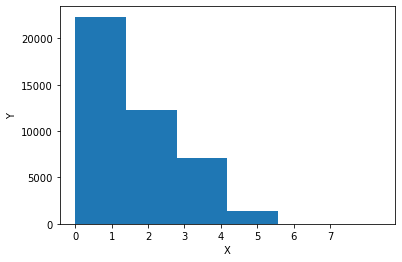

In [18]:
plt.figure()
plt.hist(np.log(arc_tract['num_surveys']),bins=6)
plt.xlabel("X")
plt.ylabel("Y")
plt.xticks(np.arange(8))
plt.show()

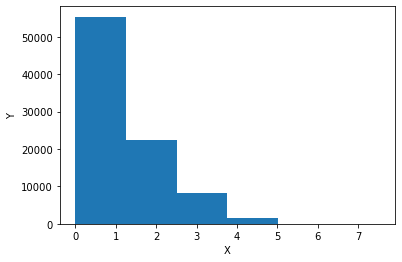

In [22]:
plt.figure()
plt.hist(np.log(arc_block['num_surveys']),bins=6)
plt.xlabel("X")
plt.ylabel("Y")
plt.xticks(np.arange(8))
plt.show()

In [20]:
np.arange(8)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [27]:
arc_block[arc_block['num_surveys'] > 30].shape[0]/ arc_block.shape[0]

0.03404958677685951

In [ ]:
blockGEOID = []
EstimateMean = []
EstimateCI   = []
EstimateGeography = []

for index, row in arc_block.head(n=2).iterrows():
    # append block GEOID-Data  
    if row['num_surveys'] > 30: 
        
    
    
